**1.Техническая часть**.  

1.1 Загрузка и чтение файлов

In [ ]:
import pandas as pd
import numpy as np

import glob


files = glob.glob("data/*.csv")  


df_list = []
for f in files:
    df = pd.read_csv(
        f,
        sep=";",        
        decimal=",",      
        encoding="utf-8-sig"  
    )
    df_list.append(df)


df = pd.concat(df_list, ignore_index=True)


print(df.shape)
df.head()


(149908, 12)


,entry_id,country,description,designation,points,price,province,region,taster_name,title,variety,winery
0,119988,France,"Big, rich and off-dry, this is powered by inte...",Lieu-dit Harth Cuvée Caroline,90,21.0,Alsace,Alsace,Rоgеr Vоss,Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...,Gewürztraminer,Domaine Schoffit
1,119988,France,"Big, rich and off-dry, this is powered by inte...",Lieu-dit Harth Cuvée Caroline,90,21.0,Alsace,Alsace,Roger Voss,Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...,Gewürztraminer,Domaine Schoffit
2,119987,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,Roger Voss,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss
3,119986,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
4,119983,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149908 entries, 0 to 149907
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   entry_id     149908 non-null  int64  
 1   country      149908 non-null  object 
 2   description  149908 non-null  object 
 3   designation  106749 non-null  object 
 4   points       149908 non-null  int64  
 5   price        139418 non-null  float64
 6   province     149908 non-null  object 
 7   region       125516 non-null  object 
 8   taster_name  118829 non-null  object 
 9   title        149908 non-null  object 
 10  variety      149906 non-null  object 
 11  winery       149908 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 13.7+ MB


In [26]:
df.describe()

,entry_id,points,price
count,149908.000000,149908.000000,139418.000000
mean,60016.358386,88.444139,35.715675
std,34665.207896,3.096604,43.032368
min,1.000000,80.000000,4.000000
25%,30032.750000,86.000000,17.000000
50%,60012.500000,88.000000,25.000000
75%,90033.250000,91.000000,42.000000
max,119988.000000,100.000000,3300.000000


1.2 Очистка данных

Проверка на дубликаты

In [27]:
df.duplicated().sum()

np.int64(15847)

In [28]:
df.duplicated(subset=["description","taster_name"]).sum()

np.int64(15867)

In [29]:
df.drop_duplicates(subset=["description","taster_name"],inplace=True)


In [30]:
df.duplicated(subset=["description","taster_name"]).sum()

np.int64(0)

Проверка на наличие кириллицы

In [31]:
# Словарь для замены кириллицы на латиницу
cyr_to_lat = {
    "А": "A", "а": "a",
    "В": "B", "Е": "E", "е": "e",
    "К": "K", "М": "M",
    "Н": "H", "О": "O", "о": "o",
    "Р": "P", "С": "C", "Т": "T",
    "Х": "X", "у": "y", "И": "I",
    "Ь": "'", "Я": "Ya", "Ё": "E",
}

# Функция замены
def fix_latin_like(text):
    return "".join(cyr_to_lat.get(c, c) for c in str(text))



In [32]:

# Применяем к столбцу, где такие “подозрительные” буквы
df["taster_name"] = df["taster_name"].apply(fix_latin_like)

In [33]:
unique_count = df["taster_name"].unique()
unique_count

array(['Roger Voss', 'Joe Czerwinski', 'Anne Krebiehl\xa0MW', 'nan',
       'Lauren Buzzeo', 'Paul Gregutt', 'Michael Schachner',
       'Jeff Jenssen', 'Mike DeSimone', 'Susan Kostrzewa',
       'Anna Lee C. Iijima', 'Sean P. Sullivan', 'Kerin O’Keefe',
       'Matt Kettmann', 'Christina Pickard', 'Virginie Boone',
       'Jim Gordon', 'Carrie Dykes', 'Alexander Peartree', 'Fiona Adams'],
      dtype=object)

In [34]:
df["taster_name"] = df["taster_name"].str.replace("\xa0", " ", regex=False)

df.loc[df["taster_name"] == "nan", "taster_name"] = "No name"

In [35]:
df["taster_name"].nunique()

20

Пропуски

In [36]:
print(df.isna().sum())

entry_id           0
country            0
description        0
designation    38448
points             0
price           9411
province           0
region         22363
taster_name        0
title              0
variety            1
winery             0
dtype: int64


In [37]:
df["designation"] = df["designation"].fillna("Unknown")
df["region"] = df["region"].fillna("Unknown")
df["variety"] = df["variety"].fillna("Unknown")

In [38]:
# Считаю медиану цены по сорту винограда и провинции там где возможно
median_prices = df.groupby(["variety","province"])['price'].median()

# Функция для заполнения пропусков
df['price'] = df.apply(
    lambda row: median_prices[row["variety"], row["province"]] if pd.isna(row["price"]) else row["price"],
    axis=1
)



In [39]:
df.isna().sum()

entry_id         0
country          0
description      0
designation      0
points           0
price          141
province         0
region           0
taster_name      0
title            0
variety          0
winery           0
dtype: int64

In [40]:
print(df.shape)

(134041, 12)


1.3 Эксплораторный анализ

In [41]:
df["points"].describe()

count    134041.000000
mean         88.457696
std           3.089504
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [42]:
df["price"].describe()

count    133900.000000
mean         35.217155
std          41.619553
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

p-value

In [43]:
print(df.groupby('variety')['price'].nunique())


variety
Abouriou        2
Agiorgitiko    22
Aglianico      58
Aidani          1
Airen           3
               ..
Zinfandel      66
Zlahtina        2
Zweigelt       33
Çalkarası       1
Žilavka         1
Name: price, Length: 702, dtype: int64


In [44]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(df['points'], df['price'])

print("Spearman r:", round(corr, 3))
print("p-value:", p_value)


Spearman r: nan
p-value: nan


In [53]:
# переведем списки в особый формат, массив Numpy
X = np.points
y = np.price
 
# зададим размер графика
plt.figure(figsize = (10,6))
 
# снова построим точечную диаграмму
plt.scatter(X, y)
 
# создадим модель с помощью функции polyfit()
# slope и intercept - это наклон и сдвиг прямой вверх-вниз
# и одновременно те самые веса модели w и b
slope, intercept = np.polyfit(X, y, 1)
 
# с их помощью построим график прямой
# каждой точке X будет соответствовать прогнозное значение X*slope + intercept
# r означает red, красный цвет линии
plt.plot(X, X * slope + intercept, 'r')
 
# добавим подписи
plt.xlabel('Рост женщин в России, м', fontsize = 16)
plt.ylabel('Обхват шеи, см', fontsize = 16)
plt.title('Зависимость роста и окружности шеи у женщин в России', fontsize = 18)


AttributeError: module 'numpy' has no attribute 'points'

В столбце с ценами присутствовало около 9 тысячи пропущенных значений, что составляет достаточно болььшую часть данных. Пропуски решила заменить на медианные значения по группе сортов винограда. Такой подход выбрала т.к ставить 0 было-бы некорректно и вводило бы в заблуждение (будто вино бесплатно), оставлять Nan или заполнять Unknown выглядело бы просто неаккуратно и неполно для анализа.Удаление записей привело бы к потери большого обЪема информации

1.4 Визуализация данных

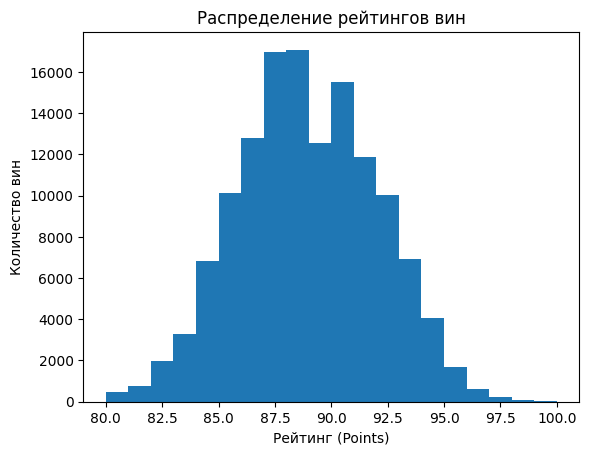

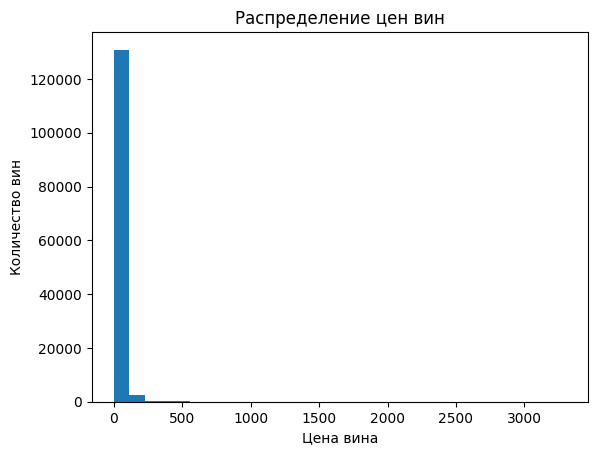

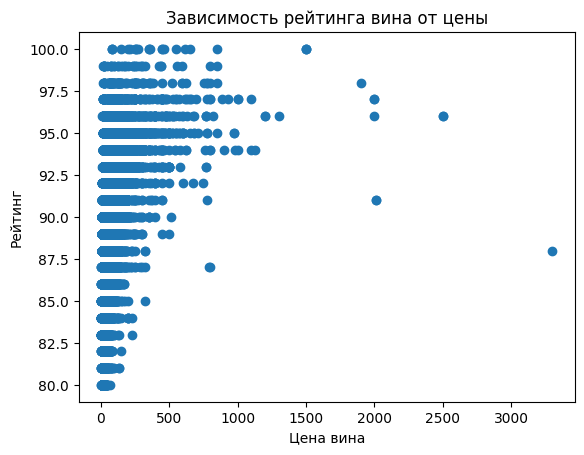

In [62]:
# Подготовка данных
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['points'] = pd.to_numeric(df['points'], errors='coerce')

plot_df = df[df['price'].notna() & df['points'].notna()]

# Гистограмма рейтингов
plt.figure()
plt.hist(plot_df['points'], bins=20)
plt.xlabel('Рейтинг (Points)')
plt.ylabel('Количество вин')
plt.title('Распределение рейтингов вин')
plt.show()

# Гистограмма цен
plt.figure()
plt.hist(plot_df['price'], bins=30)
plt.xlabel('Цена вина')
plt.ylabel('Количество вин')
plt.title('Распределение цен вин')
plt.show()

# 3Совместный график
plt.figure()
plt.scatter(plot_df['price'], plot_df['points'])
plt.xlabel('Цена вина')
plt.ylabel('Рейтинг')
plt.title('Зависимость рейтинга вина от цены')
plt.show()

Для анализа были выбраны гистограммы для цены и рейтинга, поскольку они позволяют наглядно оценить распределение количественных переменных, выявить асимметрию и наличие выбросов.
Для изучения зависимости между ценой и рейтингом была использована диаграмма рассеяния, так как она наиболее подходит для анализа связи между двумя количественными признаками и позволяет оценить характер зависимости и степень разброса данных.

В целом наблюдается слабый положительный тренд:
с ростом цены чаще встречаются более высокие рейтинги
Однако точки сильно разбросаны
Это означает: цена влияет на рейтинг, но не является решающим фактором

Высокая цена ≠ гарантированный высокий рейтинг
Видны дорогие вина (1000+), которые имеют рейтинги ~88–91
При этом есть относительно недорогие вина:
с рейтингами 95–100
Вывод: высокая цена не гарантирует выдающегося качества

Низкая цена резко ограничивает потолок рейтинга
В сегменте очень дешёвых вин практически нет оценок 95+
Большинство вин с рейтингом 90 находятся в среднем и высоком ценовом диапазоне
Это асимметричная зависимость: низкая цена — сильный ограничитель, высокая цена — лишь слабый усилитель

* Как зовут ТОП-5 самых продуктивных авторов отзывов (по числу отзывов).
* Вина из каких стран каждый из ТОП-5 в основном оценивает.

In [45]:
# 1. Чистим данные
df['taster_name'] = df['taster_name'].astype(str).str.strip()
df['country'] = df['country'].astype(str).str.strip()

# убираем реальные пропуски
df.loc[df['country'].isin(['nan', '', 'None']), 'country'] = None

# 2. ТОП-5 дегустаторов
top_tasters = (
    df[df['taster_name'].notna() & (df['taster_name'] != 'No name')]
    ['taster_name']
    .value_counts()
    .head(5)
    .index
)

In [46]:

# 3. Фильтруем по ним
df_top = df[df['taster_name'].isin(top_tasters)]

# 4. Считаем страны
countries = (
    df_top
    .groupby(['taster_name', 'country'], dropna=False)
    .size()
    .reset_index(name='reviews')
)

# 5. ТОП-5 стран ДЛЯ КАЖДОГО дегустатора
top5_countries_per_taster = (
    countries
    .sort_values(['taster_name', 'reviews'], ascending=[True, False])
    .groupby('taster_name')
    .head(5)
)

print(top5_countries_per_taster)


          taster_name       country  reviews
0       Kerin O’Keefe         Italy    10784
9   Michael Schachner         Spain     7009
3   Michael Schachner         Chile     4707
1   Michael Schachner     Argentina     4092
11  Michael Schachner       Uruguay      114
5   Michael Schachner         Italy       87
16       Paul Gregutt            US    10046
12       Paul Gregutt        Canada      182
13       Paul Gregutt        France       40
14       Paul Gregutt         Italy        4
15       Paul Gregutt         Spain        4
18         Roger Voss        France    19864
21         Roger Voss      Portugal     6018
17         Roger Voss       Austria     1231
20         Roger Voss         Italy      110
22         Roger Voss  South Africa       24
24     Virginie Boone            US    10039


* Отличаются ли ценовые диапазон вин, которые оценивает каждый из ТОП-5?

/var/folders/j7/8fjr40rj70xdbzr6nz4vflxw0000gn/T/ipykernel_7459/812583057.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_tasters, showfliers=True)


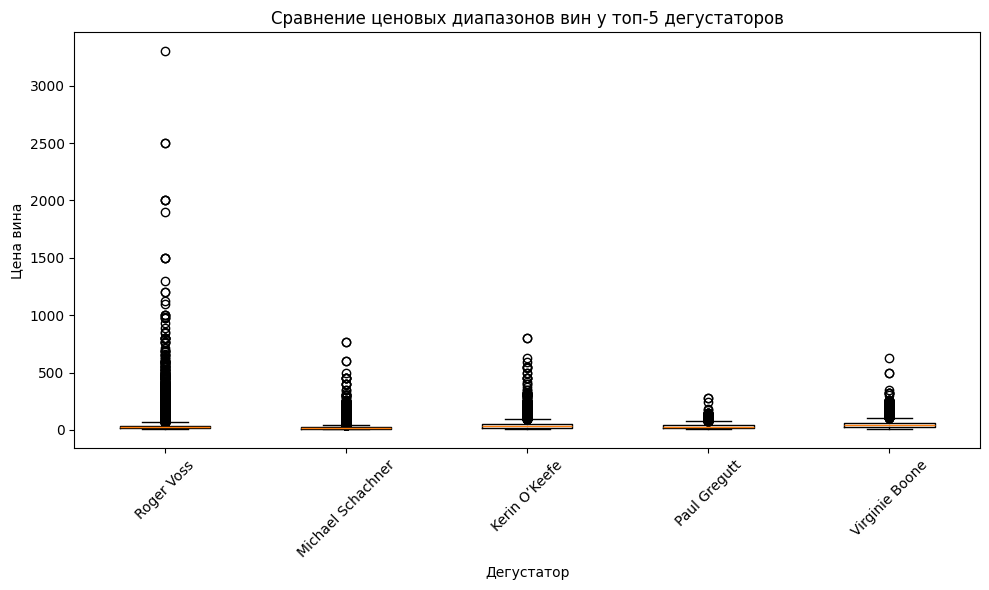

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Чистим цену
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 2. Оставляем только топ-5 дегустаторов и вина с ценой
price_df = df[
    df['taster_name'].isin(top_tasters) &
    df['price'].notna()
]

# 3. Готовим данные для boxplot
data = [
    price_df[price_df['taster_name'] == t]['price']
    for t in top_tasters
]

# 4. Строим график
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=top_tasters, showfliers=True)
plt.xticks(rotation=45)
plt.xlabel('Дегустатор')
plt.ylabel('Цена вина')
plt.title('Сравнение ценовых диапазонов вин у топ-5 дегустаторов')
plt.tight_layout()
plt.show()


* Что влияет на высокий рейтинг (90+)

In [48]:
high = df[df['points'] >= 90]
low = df[df['points'] < 90]


In [49]:
# самые часто встречаемые слова в отзывах
from collections import Counter
import re

def get_words(text_series):
    text = " ".join(text_series.dropna()).lower()
    words = re.findall(r'\b[a-z]+\b',text)
    return Counter(words)

high_words = get_words(high["description"])
low_words = get_words(low["description"])


In [50]:
markers = {
    word: high_words[word] / (low_words[word] + 1)
    for word in high_words
    if high_words[word] > 50
}

top_markers = sorted(markers.items(), key=lambda x: x[1], reverse=True)[:20]
top_markers


[('superbly', 22.333333333333332),
 ('impeccable', 21.0),
 ('stunner', 20.0),
 ('stunning', 19.666666666666668),
 ('radiant', 18.0),
 ('endlessly', 18.0),
 ('dazzling', 17.714285714285715),
 ('glorious', 17.25),
 ('exquisite', 16.0),
 ('thrilling', 15.25),
 ('extraordinary', 15.166666666666666),
 ('exquisitely', 13.5),
 ('superb', 12.761904761904763),
 ('captivating', 11.571428571428571),
 ('gorgeous', 11.05084745762712),
 ('endless', 11.0),
 ('decade', 10.947368421052632),
 ('beauty', 10.826086956521738),
 ('immense', 10.8),
 ('greatest', 9.833333333333334)]

Высокие оценки чаще получают вина в реценизях на которые встречаются вышеуказанные слова, подчеркивающие сложность, структуру выдержкки

In [51]:
# Исходя из стран
country_score = (
    df.groupby('country')['points']
    .apply(lambda x: (x >= 90).mean())
    .sort_values(ascending=False)
)

country_score.head(10)


country
England        0.851351
India          0.777778
Austria        0.603119
Germany        0.563239
Canada         0.551181
Hungary        0.455172
Switzerland    0.428571
France         0.423743
US             0.415617
Israel         0.409506
Name: points, dtype: float64

Некоторые страны демонстрируют болеее высокую долю вин с рейтингом +90